# Metapath-visits HGCN


In [1]:
import numpy as np
from torch_geometric.utils.convert import from_networkx
from sklearn.model_selection import train_test_split
import networkx as nx 
import pickle
import matplotlib.pyplot as plt


filename = "Data/symmetricPath"

In [2]:
# Reading the metapath (pathsim-based) overall similarity matrix
with open(f'{filename}/data.pickle', 'rb') as file:
    data = pickle.load(file)


# Reading the nodes of the similarity matrix
with open(f'{filename}/patients.pickle', 'rb') as file:
    Patients = pickle.load(file)

with open(f'{filename}/visits.pickle', 'rb') as file:
    visits = pickle.load(file)

with open(f'{filename}/medication.pickle', 'rb') as file:
    Medications = pickle.load(file)

with open(f'{filename}/diagnosis.pickle', 'rb') as file:
    Diagnosis = pickle.load(file)

with open(f'{filename}/procedures.pickle', 'rb') as file:
    Procedures = pickle.load(file)

with open(f'{filename}/visitsLOS.pickle', 'rb') as file:
    visitsLOS = pickle.load(file)

# Reading Length of Stay on the visits.
newVisitsLOS = {v: visitsLOS[v] for v in visits}

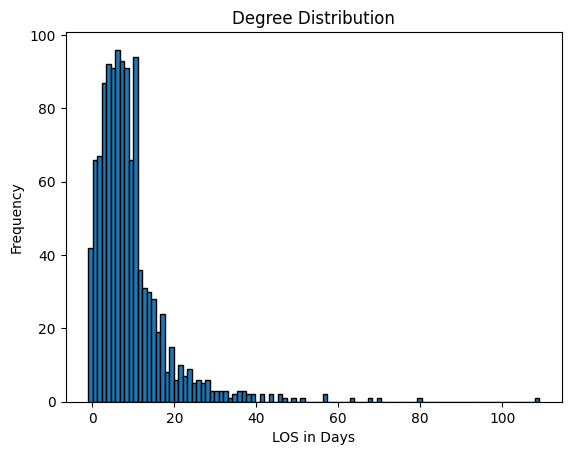

Less than 5 days = 445
More than 15 days = 189
5<LOS<15 = 537


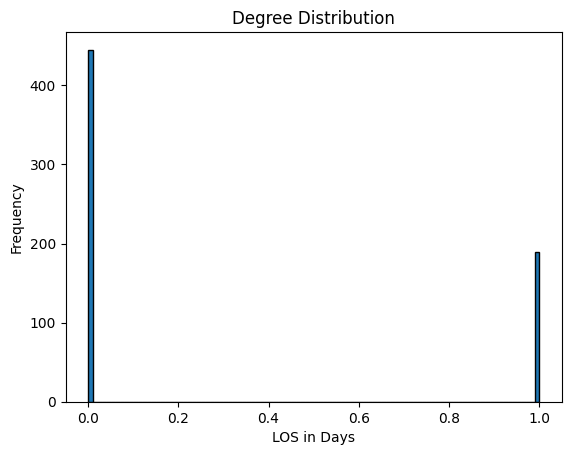

In [3]:
someK = 99999

# Setting the graph based on the similarity matrix
G = nx.Graph()

Nodes = Patients + visits + Medications + Diagnosis  + Procedures
G.add_nodes_from(Nodes)

# ------------------------------------------------------------------------
for node in G.nodes:
    if node[0]=='V':
        G.nodes[node]['y'] = newVisitsLOS[node]
    else:
        G.nodes[node]['y'] = someK

degrees = [G.nodes[node]['y'] for node in G.nodes if G.nodes[node]['y']!=someK]
plt.hist(degrees, bins=100, edgecolor='k')  
plt.xlabel('LOS in Days')
plt.ylabel('Frequency')
plt.title('Degree Distribution')
plt.show()
# ------------------------------------------------------------------------
# splitting the LOS into binary labels. 
a,b,c = 0,0,0
L, H = 5, 15
for node in G.nodes:
    if node[0]=='V':
        if G.nodes[node]['y']<=L:
            G.nodes[node]['y']=0
            a+=1

        elif G.nodes[node]['y']>L and G.nodes[node]['y']<H:
            G.nodes[node]['y']=someK
            b+=1

        elif G.nodes[node]['y']>=H:
            G.nodes[node]['y']=1
            c+=1

print(f'Less than {L} days = {a}\nMore than {H} days = {c}\n{L}<LOS<{H} = {b}')

# ------------------------------------------------------------------------# Plotting the frequency of LOS...
degrees = [G.nodes[node]['y'] for node in G.nodes if G.nodes[node]['y']!=someK]
plt.hist(degrees, bins=100, edgecolor='k')  
plt.xlabel('LOS in Days')
plt.ylabel('Frequency')
plt.title('Degree Distribution')
plt.show()


In [4]:
# assign the weight of the edges into the graph
for i, v in enumerate(Nodes):
    for j, u in enumerate(Nodes):
        if data[i][j]>0:
            G.add_edge(v, u, weight=data[i][j])

# ------------------------------------------------------------------------
# X = np.random.randn(len(list(G.nodes())), 128)
X = np.eye(len(list(G.nodes())))

for i, node in enumerate(list(G.nodes())):
    G.nodes[node]['x'] = X[i]

In [5]:
# Creating the data structure
data = from_networkx(G)

c:\Anaconda3\envs\GNNenv\Lib\site-packages\torch_geometric\utils\convert.py:249: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  data[key] = torch.tensor(value)


## Creating new masks out of visits nodes only

In [6]:
newY = []

# extracting the visits nodes and their indexes for the learning process.
for i,v in enumerate(list(data.y)):
    if v!=someK:
        newY.append([i,v])

In [7]:
y_train, y_left = train_test_split(newY    , train_size=0.7, random_state=42)
y_val,   y_test = train_test_split(y_left  , test_size=2/3 , random_state=42)

# Create masks for train, validation, and test sets
train_mask = np.zeros(len(data.y), dtype=bool)
val_mask   = np.zeros(len(data.y), dtype=bool)
test_mask  = np.zeros(len(data.y), dtype=bool)

for i,v in y_train:
    train_mask[i] = True

for i,v in y_val:
    val_mask[i] = True

for i, v in y_test:
    test_mask[i] = True

print(train_mask.shape)
print(val_mask.shape)
print(test_mask.shape)

total = len(newY)
print('Train = ', sum([1 if v else 0 for v in train_mask])/total)
print('Val = ',   sum([1 if v else 0 for v in val_mask])  /total)
print('Test = ',  sum([1 if v else 0 for v in test_mask]) /total)

(2821,)
(2821,)
(2821,)
Train =  0.6987381703470031
Val =  0.09936908517350158
Test =  0.20189274447949526


In [8]:
data.train_mask = train_mask
data.test_mask  = test_mask
data.val_mask   = val_mask

Epoch: 010, Train Loss: 0.658, Val Acc: 0.730
Epoch: 020, Train Loss: 0.630, Val Acc: 0.730
Epoch: 030, Train Loss: 0.612, Val Acc: 0.730
Epoch: 040, Train Loss: 0.602, Val Acc: 0.730
Epoch: 050, Train Loss: 0.597, Val Acc: 0.730


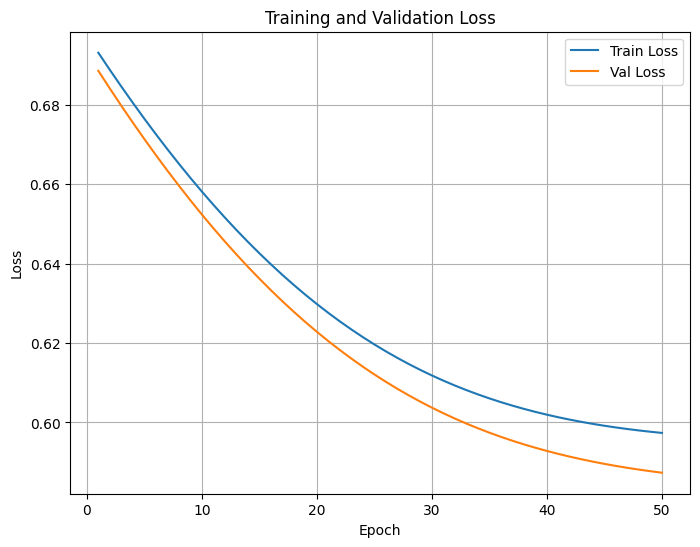

[[81  0]
 [47  0]]
F1 score =  0.3875598086124402
Precision score =  0.31640625
AUC Precision score =  0.3671875
Test Acc: 0.633



c:\Anaconda3\envs\GNNenv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
import GNNModel as GNNM
import torch

data.x = data.x.float()
data.y = data.y.long()
num_classes = 2

# Check if a GPU is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data = data.to(device)
gcn = GNNM.GCN(data.num_node_features, num_classes).to(device)

optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
gcn, df = GNNM.train_node_classifier(gcn, data, optimizer_gcn, criterion, n_epochs=50)

GNNM.plt_performance(df)
# ----------------------------------------------------------------------------
pred = gcn(data).argmax(dim=1)

pred    = pred  [data.test_mask].detach().cpu().numpy()
correct = data.y[data.test_mask].detach().cpu().numpy()

GNNM.create_confusion_matrix(pred, correct)


test_acc, _ = GNNM.eval_node_classifier(gcn, data, data.test_mask)
print(f'Test Acc: {test_acc:.3f}\n')

In [10]:
# import GNNModel as GNNM
# import torch

# data.x = data.x.float()
# data.y = data.y.float()

# # Check if a GPU is available, otherwise use CPU
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data = data.to(device)
# gcn = GNNM.GCNRegression(data.num_node_features).to(device)

# optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)
# # criterion = torch.nn.CrossEntropyLoss()
# criterion = nn.MSELoss()
# gcn, df = GNNM.train_node_classifier(gcn, data, optimizer_gcn, criterion, n_epochs=25)
# # ----------------------------------------------------------------------------

# pred = gcn(data).argmax(dim=1)

# pred = pred[data.test_mask] .detach().cpu().numpy()
# correct = data.y[data.test_mask].detach().cpu().numpy()

# [(pred[i], correct[i]) for i in range(len(correct))]

# import matplotlib.pyplot as plt

# # Assuming you have already defined 'pred' and 'correct'

# # Create a scatter plot
# plt.figure(figsize=(8, 6))
# plt.scatter(correct, pred, c='blue', alpha=0.6, edgecolors='k')

# # Add labels and title
# plt.xlabel('Actual Values (correct)')
# plt.ylabel('Predicted Values (pred)')
# plt.title('Predicted vs. Actual Values')

# # Add a diagonal line for reference (perfect prediction)
# plt.plot([min(correct), max(correct)], [min(correct), max(correct)], linestyle='--', color='red', linewidth=2)
# plt.legend()
# # Show the plot
# plt.show()


# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# import numpy as np

# # Actual target values (ground truth)
# actual_values = correct

# # Predicted values from your regression model
# predicted_values = pred

# # Calculate and print Mean Absolute Error (MAE)
# mae = mean_absolute_error(actual_values, predicted_values)
# print(f"Mean Absolute Error (MAE): {mae:.2f}")

# # Calculate and print Mean Squared Error (MSE)
# mse = mean_squared_error(actual_values, predicted_values)
# print(f"Mean Squared Error (MSE): {mse:.2f}")

# # Calculate and print Root Mean Squared Error (RMSE)
# rmse = np.sqrt(mse)
# print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# # Calculate and print R-squared (R²)
# r_squared = r2_score(actual_values, predicted_values)
# print(f"R-squared (R²): {r_squared:.2f}")


# # GNNM.create_confusion_matrix(pred, correct)


# # test_acc, _ = GNNM.eval_node_classifier(gcn, data, data.test_mask)
# # print(f'Test Acc: {test_acc:.3f}\n')